Includes:

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sn
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from data_paths import get_file_paths_ordered
from tf_lite_conversion import convert_to_tf_lite, eval_tf_lite_model
from pre_process import choose_tot_slice_len, get_data_tensors, compute_mfccs
from models import get_model

Number of speakers and the percentage of the available samples to use to consider:

In [2]:
model_name = 'test_8_spk'

# Number of speakers and the percentage of the available samples to use to consider:
num_speakers = 8
dataset_percentage = 1. # 0.85
segmentLength=1024
print("Number of speakers : ", num_speakers)

Number of speakers :  8


Save Locations

In [3]:

model_dir_root = './Models/'+ f'{model_name}/'

path_keras_model = model_dir_root + 'KerasModels/'
path_tf_lite_nq = model_dir_root + 'TFLiteModelsNonQuantized/'
path_tf_lite_q = model_dir_root + 'TFLiteModelsQuantized/'
path_c_model = model_dir_root + 'TFLiteModelsQuantized/'

# Create the directories
paths = [path_keras_model, path_tf_lite_nq, path_tf_lite_q, path_c_model]
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

print('Models will be saved to: ', model_dir_root)


model_name_keras = 'keras_'+ model_name + '.h5'
model_name_tf_lite_nq = 'tflite_nq_'+ model_name + '.tflite'
model_name_tf_lite_q = 'tflite_q_'+ model_name + '.tflite'
# model_name_c = 'c_' + model_name

Models will be saved to:  ./Models/test_8_spk/


Read data:

Total number of speakers in the original dataset: 25
Original number of files per speaker :  [1002, 656, 589, 570, 489, 476, 468, 426]
Training number of files per speaker :  3180


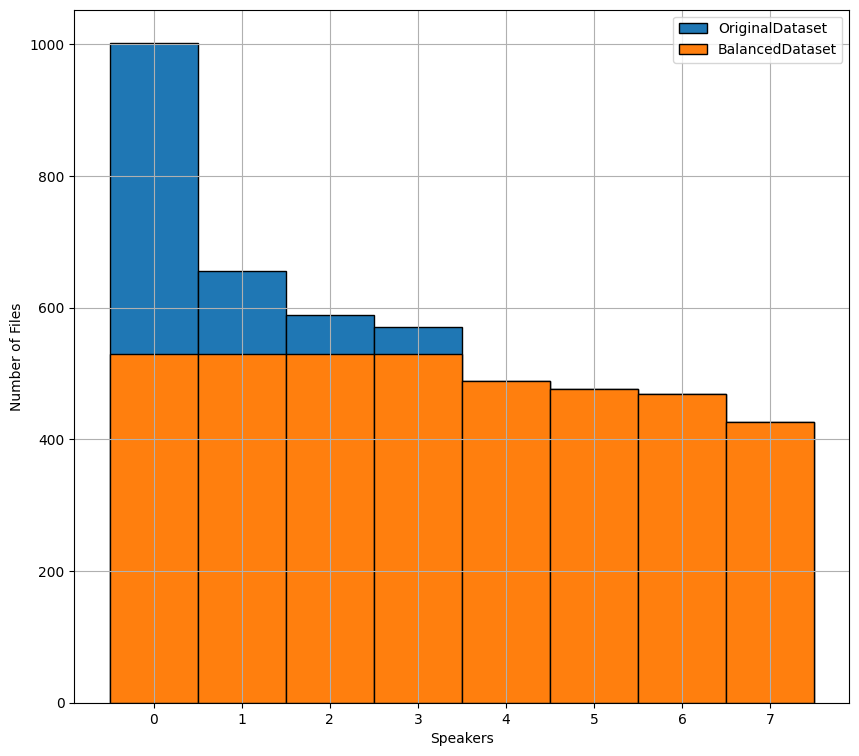

Visualization of the samples ...


100%|██████████| 3975/3975 [00:00<00:00, 10320.81it/s]


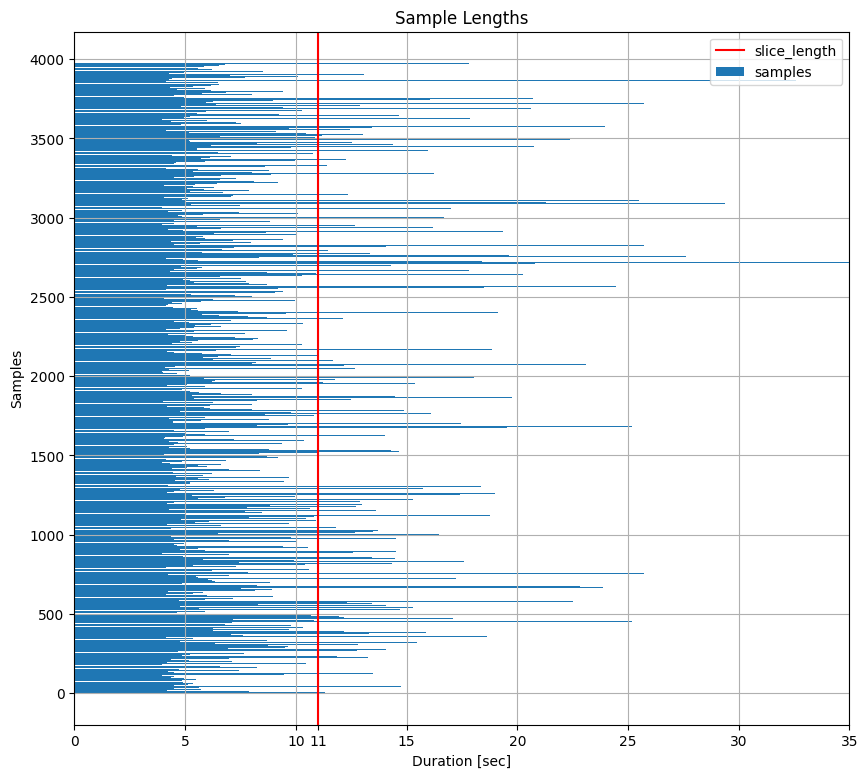

100%|██████████| 795/795 [00:00<00:00, 834.91it/s]


In [4]:
paths_train, paths_test, y_train_l, y_test_l, all_paths_l = \
    get_file_paths_ordered(num_speaker=num_speakers, test_ratio=0.2, balanced_dataset=True, plot_data=True)

slice_len = choose_tot_slice_len(paths=all_paths_l, visualize=True)

f_s, x_train, y_train, x_test, y_test = get_data_tensors(paths_train=paths_train, paths_test=paths_test, 
                                                         y_train_l=y_train_l, y_test_l=y_test_l,
                                                         tot_slice_len=slice_len,
                                                         used_train_sz_rat=dataset_percentage, 
                                                         used_test_sz_rat=1.,
                                                         segmentLength=segmentLength)

@TODO play some of the speakers as an example

Pre-Processing:

In [5]:
f_low=80.
f_up=7600.
num_mel_bins=80
num_mfcc=13

with tf.device("/cpu:0"):
    x_train_mfcc = compute_mfccs(x_train, frame_length=segmentLength, sample_rate=f_s, 
                                lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                                num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)
    x_test_mfcc  = compute_mfccs(x_test, frame_length=segmentLength, sample_rate=f_s, 
                                lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                                num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)

# Model:

In [6]:
train_set = x_train_mfcc
test_set = x_test_mfcc

In [7]:
model_idx = 0
input_shape = train_set.shape
model = get_model(input_shape=input_shape, nb_classes=num_speakers, model_idx=model_idx)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (3180, 171, 13, 1)       3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (3180, 171, 13, 3)        30        
                                                                 
 batch_normalization (BatchN  (3180, 171, 13, 3)       12        
 ormalization)                                                   
                                                                 
 activation (Activation)     (3180, 171, 13, 3)        0         
                                                                 
 conv2d_1 (Conv2D)           (3180, 86, 7, 16)         448       
                                                                 
 batch_normalization_1 (Batc  (3180, 86, 7, 16)        6

Define learning parameters:

In [8]:
batchSize = 32 #8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 100 #40 # nb of back propagations
loss_fct = 'sparse_categorical_crossentropy'

Compile the model and Fit the Data:

In [9]:
model.compile(
    loss=loss_fct, 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(path_keras_model + model_name_keras, save_best_only=True),
    # keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=20, min_lr=1.0e-5,verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),       
]

history_keras = model.fit(x=train_set, 
                          y=y_train, 
                          batch_size=batchSize, 
                          epochs=epochs, 
                          validation_split=0.2,
                          callbacks = callbacks)

Epoch 1/100
80/80 [==============================] - 4s 8ms/step - loss: 1.5614 - accuracy: 0.4595 - val_loss: 2.0931 - val_accuracy: 0.1824
Epoch 2/100
80/80 [==============================] - 0s 4ms/step - loss: 0.8754 - accuracy: 0.7009 - val_loss: 2.9885 - val_accuracy: 0.1808
Epoch 3/100
80/80 [==============================] - 0s 4ms/step - loss: 0.6628 - accuracy: 0.7909 - val_loss: 3.5864 - val_accuracy: 0.3192
Epoch 4/100
80/80 [==============================] - 0s 4ms/step - loss: 0.5649 - accuracy: 0.8078 - val_loss: 3.4972 - val_accuracy: 0.3082
Epoch 5/100
80/80 [==============================] - 0s 5ms/step - loss: 0.4693 - accuracy: 0.8498 - val_loss: 2.4555 - val_accuracy: 0.4340
Epoch 6/100
80/80 [==============================] - 0s 4ms/step - loss: 0.4241 - accuracy: 0.8557 - val_loss: 2.3945 - val_accuracy: 0.4167
Epoch 7/100
80/80 [==============================] - 0s 5ms/step - loss: 0.4209 - accuracy: 0.8506 - val_loss: 0.8967 - val_accuracy: 0.6871
Epoch 8/100
8

Evaluate the performance on the test set:

In [10]:
y_pred = model.predict(x_test_mfcc)

test_loss, test_acc = model.evaluate(x_test_mfcc,  y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

25/25 [==============================] - 0s 2ms/step
25/25 - 0s - loss: 0.3566 - accuracy: 0.9031 - 64ms/epoch - 3ms/step
Test accuracy: 0.9031446576118469
Test loss: 0.3566189408302307


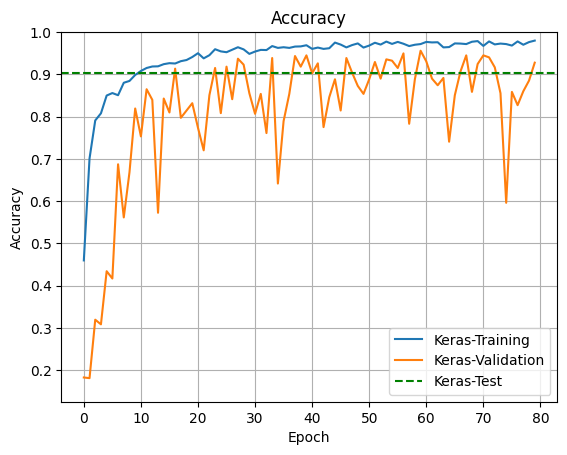

In [11]:
plt.figure()
plt.plot(history_keras.history['accuracy'], label='Keras-Training')
plt.plot(history_keras.history['val_accuracy'], label='Keras-Validation')
plt.axhline(y=test_acc, xmin=0, xmax=epochs, linestyle='--', color='g', label='Keras-Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([1/num_speakers, 1])
plt.legend(loc='lower right')
plt.grid()
plt.title("Accuracy")
plt.show()

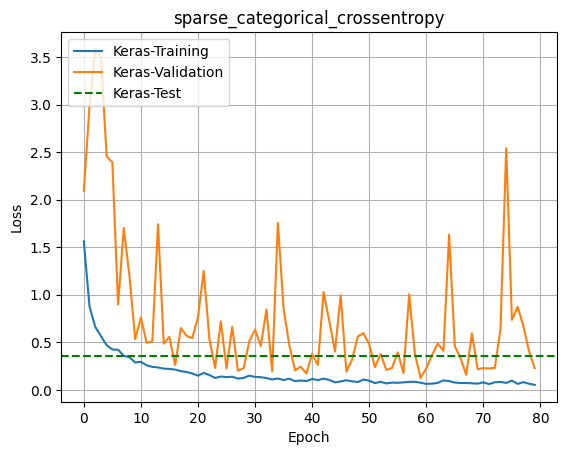

In [12]:
plt.figure()
plt.plot(history_keras.history['loss'], label='Keras-Training')
plt.plot(history_keras.history['val_loss'], label='Keras-Validation')
plt.axhline(y=test_loss, xmin=0, xmax=epochs, linestyle='--', color='g', label='Keras-Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid()
plt.title(loss_fct)
plt.show()

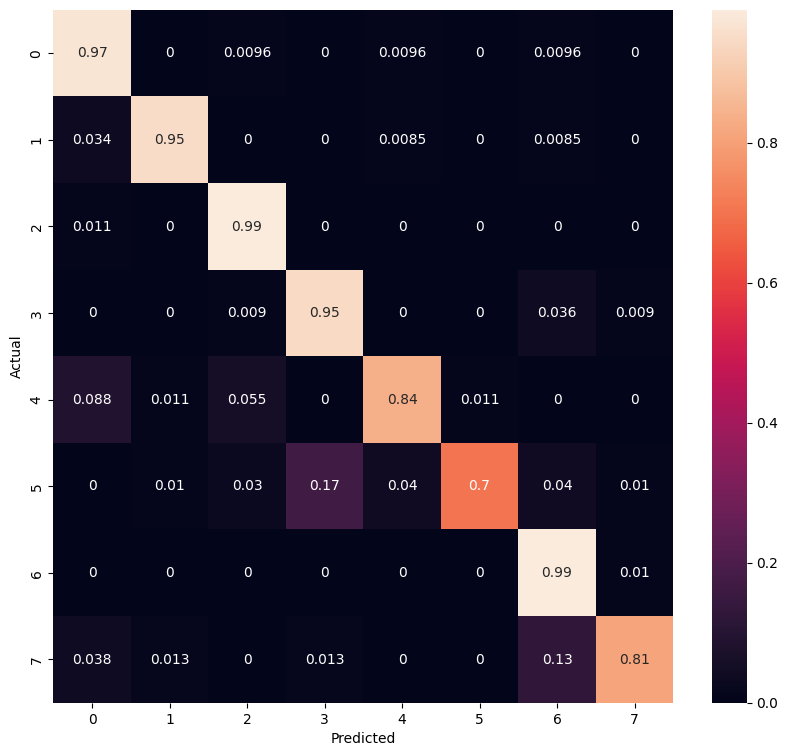

In [13]:
y_pred_hard = np.argmax(y_pred, axis=1)
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, y_pred_hard, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Information about the saved Kerras Model on disk:

In [14]:
h5_in_kb = os.path.getsize(path_keras_model+model_name_keras) / 1024
print("Keras model file : ", model_name_keras)
print("HDF5 Keras Model size: %d KB" % h5_in_kb)

Keras model file :  keras_test_8_spk.h5
HDF5 Keras Model size: 391 KB


# TF Lite Conversion and Quantization:

In [15]:
print(train_set.numpy().shape)

(3180, 171, 13, 1)


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmpf7699rdw\assets


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmpf7699rdw\assets


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmpazwfc5ck\assets


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmpazwfc5ck\assets
c:\Users\kerem\anaconda3\envs\ml_mcu_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


HDF5 Model size without quantization: 391 KB
TFLite Model size without quantization: 100 KB

Reduction in model size from Keras to TFLite by a factor of 3.908109
Quantized TFLite Model size: 33 KB

Reduction in model size from Keras to TFLiteQuantized by a factor of 11.821614


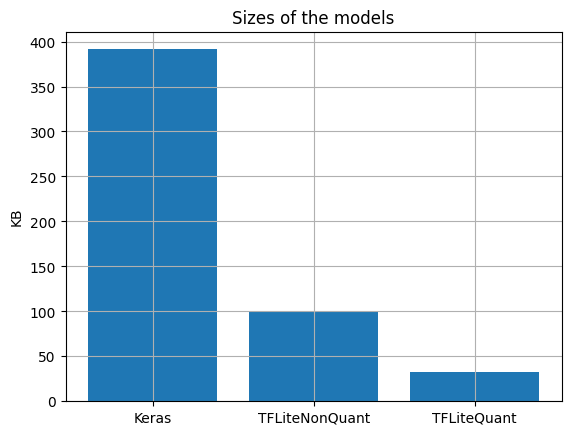

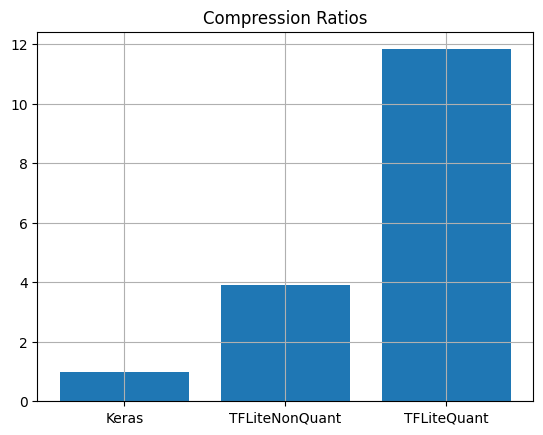

In [16]:
tflite_model_nq, tflite_model_q = \
    convert_to_tf_lite(keras_model=model,
                       path_keras_model=path_keras_model + model_name_keras, 
                       path_tf_lite_nq_model=path_tf_lite_nq + model_name_tf_lite_nq,
                       train_set=train_set, 
                       path_tf_lite_q_model=path_tf_lite_q + model_name_tf_lite_q)

# Performance evaluation Non-Quantized Model

In [17]:
pred_nq = eval_tf_lite_model(path_tf_lite_model=path_tf_lite_nq + model_name_tf_lite_nq,
                             test_set=test_set, 
                             quantized=False)

Evaluated model:  ./Models/test_8_spk/TFLiteModelsNonQuantized/tflite_nq_test_8_spk.tflite
Input shape is [  1 171  13   1] and of type <class 'numpy.float32'>
Output shape is [1 8] and of type <class 'numpy.float32'>


In [18]:
tflite_nq_score = accuracy_score(y_test, pred_nq)
print("Accuracy of quantized to int8 model is {}%".format(tflite_nq_score*100))
print("Compared to float32 accuracy of {}%".format(test_acc*100))
print("We have a change of {}%".format((tflite_nq_score-test_acc)*100))

Accuracy of quantized to int8 model is 90.31446540880503%
Compared to float32 accuracy of 90.31446576118469%
We have a change of -3.523796587856509e-07%


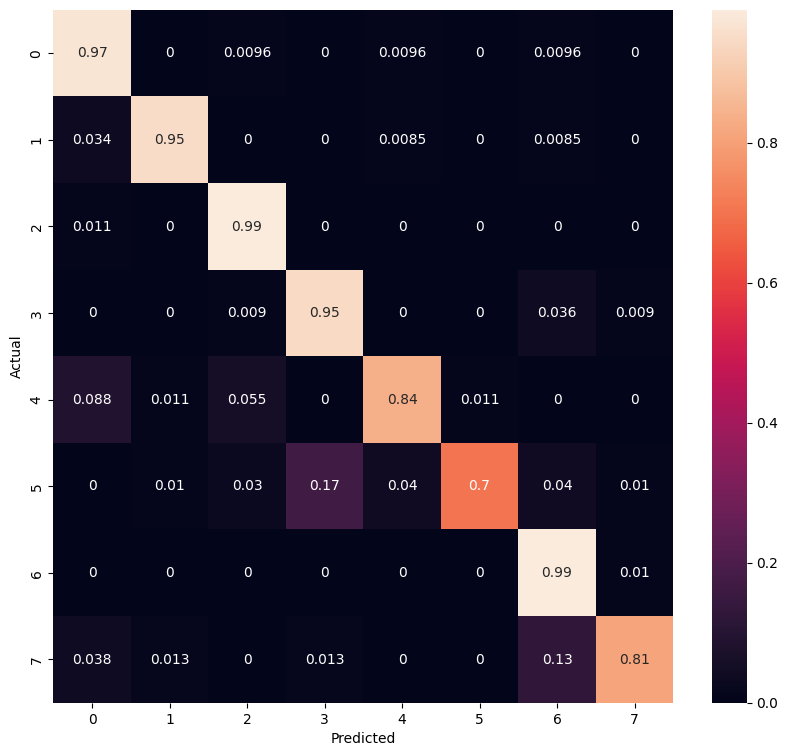

In [19]:
plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, pred_nq, 
                      normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Performance evaluation Quantized Model

In [20]:
pred_q = eval_tf_lite_model(path_tf_lite_model=path_tf_lite_q + model_name_tf_lite_q,
                            quantized=True, 
                            test_set=test_set)

Evaluated model:  ./Models/test_8_spk/TFLiteModelsQuantized/tflite_q_test_8_spk.tflite
Input shape is [  1 171  13   1] and of type <class 'numpy.int8'>
Output shape is [1 8] and of type <class 'numpy.int8'>


In [21]:
tflite_q_score = accuracy_score(y_test, pred_q)
print("Accuracy of quantized to int8 model is {}%".format(tflite_q_score*100))
print("Compared to float32 accuracy of {}%".format(test_acc*100))
print("We have a change of {}%".format((tflite_q_score-test_acc)*100))

Accuracy of quantized to int8 model is 75.72327044025158%
Compared to float32 accuracy of 90.31446576118469%
We have a change of -14.591195320933114%


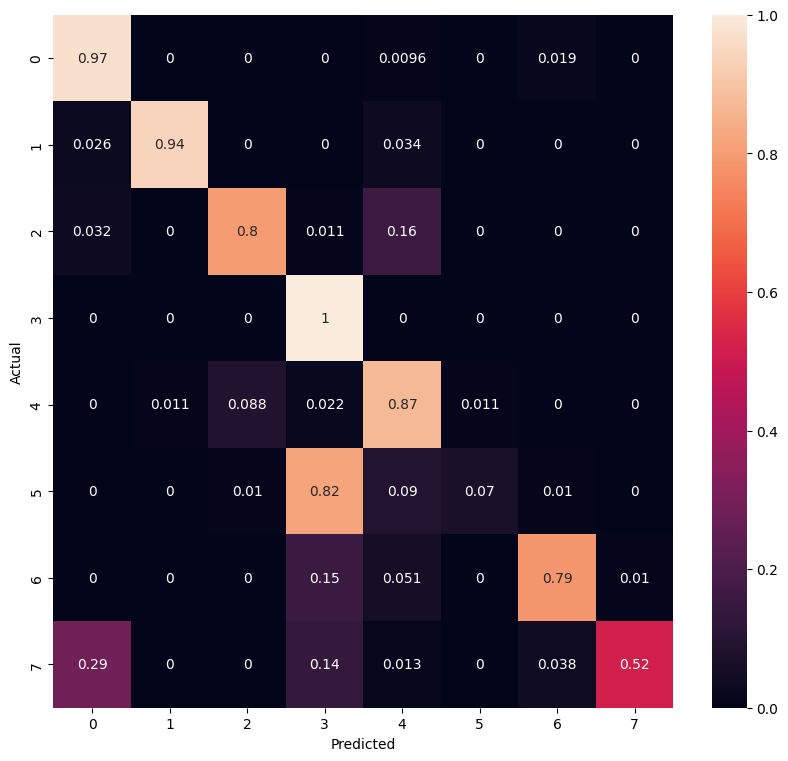

In [22]:
plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, pred_q, 
                      normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy comparison

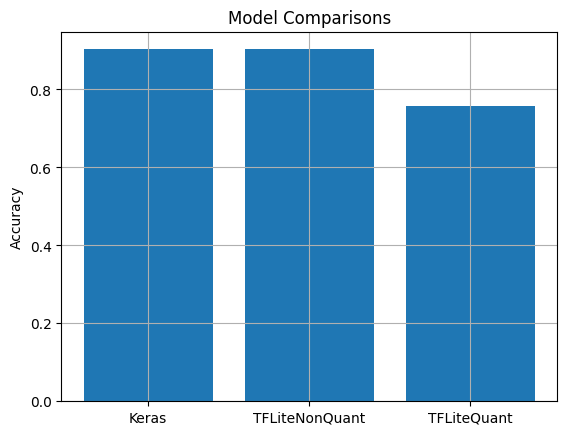

In [23]:
plt.figure()
plt.bar(['Keras', 'TFLiteNonQuant', 'TFLiteQuant'], [test_acc, tflite_nq_score, tflite_q_score])
plt.ylabel("Accuracy")
plt.title("Model Comparisons")
plt.grid()